# Explanation of the Code and Functional Analysis

The code simulates a generative adversarial training process where a generator progressively learns to approximate a target probability distribution. The generator starts with a poor approximation and gradually converges to the true distribution over a sequence of training iterations. The discriminator, modeled as a logistic function, estimates the probability of a sample being real by comparing the probability density functions (PDFs) of the true and generated distributions. The training progress is visualized through an animated plot displaying the real data distribution, the evolving generator distribution, and the discriminator's output. The real data is assumed to follow a normal distribution:

$$
p_{\text{data}}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

where the function `compute_ground_truth(x, mean=5, std=1)` evaluates this probability density function (PDF) for a given range of values. The generator's distribution is initialized with a different mean and standard deviation and gradually interpolates toward the real distribution. The function `compute_generator_pdf(x, frame, total_frames, init_mean=2, init_std=2, target_mean=5, target_std=1)` defines this transition using linear interpolation:

$$
\mu_G(t) = \mu_{\text{init}} + t (\mu_{\text{target}} - \mu_{\text{init}})
$$

$$
\sigma_G(t) = \sigma_{\text{init}} + t (\sigma_{\text{target}} - \sigma_{\text{init}})
$$

where $t$ is a normalized time variable ranging from 0 to 1. This ensures that the generator's output distribution smoothly converges to the real distribution over the animation frames. The discriminator is modeled as a logistic function of the difference between the real and generated PDFs:

$$
D(x) = \frac{1}{1 + \exp\left(-\lambda (p_G(x) - p_{\text{data}}(x))\right)}
$$

where $\lambda$ is a scaling factor controlling the discriminator's sensitivity. This is computed in the function `compute_discriminator_prob(real_pdf, gen_pdf, factor=10)`. The training process is simulated in `simulate_training(x, num_frames)`, which iterates over a fixed number of frames, computing the generator’s PDF and discriminator outputs at each step. The real PDF remains constant, while the generated PDF and discriminator probabilities evolve over time. To visualize this process, the function `create_animation(x, ground_truth_data, generator_data, discriminator_data, num_frames, interval=200)` creates an animated plot where each frame represents an epoch. The animation includes:

- The real data distribution as a dashed black curve.
- The generator's evolving distribution as a green curve.
- The discriminator’s output as a blue curve.

Finally, the animation is saved in MP4 and GIF formats using `save_animation(ani, "gan_training_progress.mp4", "gan_training_progress.gif", fps=10)`, ensuring compatibility for different viewing platforms. Overall, this implementation effectively illustrates how a generator progressively refines its approximation of a target distribution through a simulated training process. The visual representation provides insights into the convergence behavior of generative models and the role of the discriminator in distinguishing between real and generated samples.


Ground truth data shape: (30, 100)
Generator data shape: (30, 100)
Discriminator data shape: (30, 100)


<IPython.core.display.Javascript object>


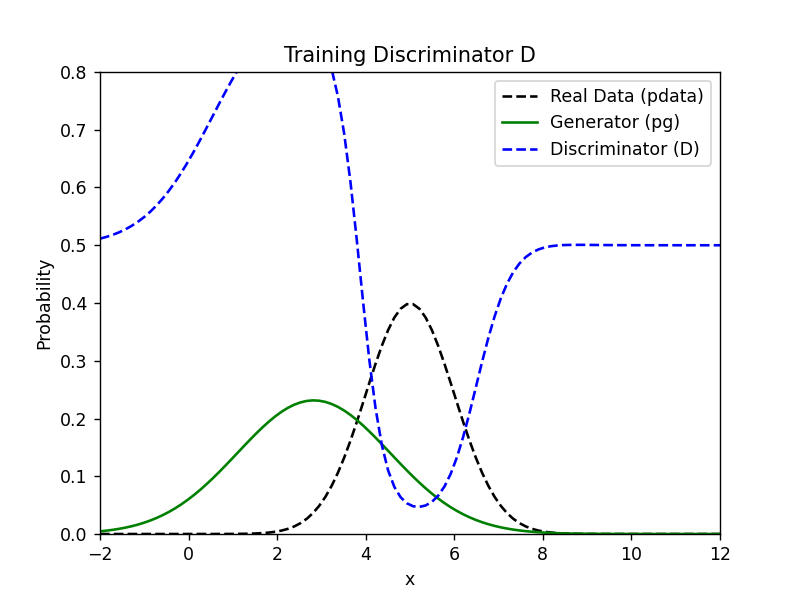

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from scipy.stats import norm
%matplotlib notebook

# ---------------------------
# Data and Simulation Functions
# ---------------------------
def compute_ground_truth(x, mean=5, std=1):
    """
    Compute the ground truth PDF for x using a normal distribution.
    
    Args:
        x (np.ndarray): 1D array of x-values.
        mean (float): Mean of the real distribution.
        std (float): Standard deviation of the real distribution.
        
    Returns:
        np.ndarray: Ground truth PDF values.
    """
    return norm.pdf(x, mean, std)

def compute_generator_pdf(x, frame, total_frames, init_mean=2, init_std=2, target_mean=5, target_std=1):
    """
    Compute the generator's PDF for the given frame by linearly interpolating 
    its parameters from initial to target values. This makes the generated data 
    converge to the ground truth.
    
    Args:
        x (np.ndarray): 1D array of x-values.
        frame (int): Current frame (epoch) index.
        total_frames (int): Total number of frames.
        init_mean (float): Initial mean of the generator's distribution.
        init_std (float): Initial standard deviation of the generator's distribution.
        target_mean (float): Target mean (should match ground truth).
        target_std (float): Target standard deviation (should match ground truth).
        
    Returns:
        np.ndarray: Generator PDF values for this frame.
    """
    t = frame / (total_frames - 1)  # t varies from 0 to 1
    gen_mean = init_mean + (target_mean - init_mean) * t
    gen_std = init_std + (target_std - init_std) * t
    return norm.pdf(x, gen_mean, gen_std)

def compute_discriminator_prob(real_pdf, gen_pdf, factor=10):
    """
    Simulate the discriminator's output as a logistic function of the difference
    between generator and real PDFs.
    
    Args:
        real_pdf (np.ndarray): Ground truth PDF values.
        gen_pdf (np.ndarray): Generator PDF values.
        factor (float): Scaling factor for the logistic function.
        
    Returns:
        np.ndarray: Discriminator probability outputs.
    """
    return 1 / (1 + np.exp(-(gen_pdf - real_pdf) * factor))

def simulate_training(x, num_frames):
    """
    Simulate the training process over a specified number of frames.
    The generated PDF converges linearly to the ground truth PDF.
    
    Args:
        x (np.ndarray): 1D array of x-values.
        num_frames (int): Number of simulation frames.
        
    Returns:
        tuple: (ground_truth_data, generator_data, discriminator_data)
               Each is a NumPy array of shape (num_frames, len(x)).
    """
    ground_truth_list = []
    generator_list = []
    discriminator_list = []
    
    # Ground truth PDF remains constant throughout the simulation
    real_pdf = compute_ground_truth(x)
    
    for frame in range(num_frames):
        gen_pdf = compute_generator_pdf(x, frame, num_frames)
        disc_pdf = compute_discriminator_prob(real_pdf, gen_pdf)
        
        ground_truth_list.append(real_pdf)
        generator_list.append(gen_pdf)
        discriminator_list.append(disc_pdf)
    
    return (np.array(ground_truth_list), 
            np.array(generator_list), 
            np.array(discriminator_list))

# ---------------------------
# Animation Functions
# ---------------------------
def create_animation(x, ground_truth_data, generator_data, discriminator_data, num_frames, interval=200):
    """
    Create an animation using precomputed data.
    
    Args:
        x (np.ndarray): 1D array of x-values.
        ground_truth_data (np.ndarray): Array of ground truth PDFs (num_frames x len(x)).
        generator_data (np.ndarray): Array of generator PDFs (num_frames x len(x)).
        discriminator_data (np.ndarray): Array of discriminator outputs (num_frames x len(x)).
        num_frames (int): Number of frames.
        interval (int): Delay between frames in milliseconds.
        
    Returns:
        tuple: (ani, fig) where ani is the FuncAnimation object and fig is the figure.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(0, 0.8)
    ax.set_title("Training Discriminator D")
    ax.set_xlabel("x")
    ax.set_ylabel("Probability")
    
    real_line, = ax.plot([], [], 'k--', label='Real Data (pdata)')
    fake_line, = ax.plot([], [], 'g-', label='Generator (pg)')
    disc_line, = ax.plot([], [], 'b--', label='Discriminator (D)')
    ax.legend()
    
    def update(frame):
        real_line.set_data(x, ground_truth_data[frame])
        fake_line.set_data(x, generator_data[frame])
        disc_line.set_data(x, discriminator_data[frame])
        return real_line, fake_line, disc_line
    
    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=interval, blit=True)
    return ani, fig

def save_animation(ani, mp4_filename, gif_filename, fps=10):
    """
    Save the animation in both MP4 and GIF formats.
    
    Args:
        ani (FuncAnimation): The animation object.
        mp4_filename (str): Output filename for MP4.
        gif_filename (str): Output filename for GIF.
        fps (int): Frames per second.
    """
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Your Name'),
                           extra_args=['-vcodec', 'libx264'])
    ani.save(mp4_filename, writer=writer)
    ani.save(gif_filename, writer='pillow', fps=fps)

# ---------------------------
# Direct Function Calls (No main function)
# ---------------------------

# Define x-range and simulation parameters
x = np.linspace(-2, 12, 100)
num_frames = 30

# Simulate training: all data is stored in arrays
ground_truth_data, generator_data, discriminator_data = simulate_training(x, num_frames)
print("Ground truth data shape:", ground_truth_data.shape)
print("Generator data shape:", generator_data.shape)
print("Discriminator data shape:", discriminator_data.shape)

# Create and display the animation
ani, fig = create_animation(x, ground_truth_data, generator_data, discriminator_data, num_frames)
plt.show()

# Save the animation in MP4 and GIF formats
save_animation(ani, "gan_training_progress.mp4", "gan_training_progress.gif", fps=10)


# Explanation of the Code and Functional Analysis

The provided code implements a simplified Generative Adversarial Network (GAN) training setup, where two generator models are trained independently to approximate a target distribution. The target distribution is a univariate normal distribution with mean $\mu = 5$ and standard deviation $\sigma = 1$. The training process involves generating synthetic samples and optimizing the generators using a simple loss function. Additionally, an animated visualization is created to illustrate the evolution of the generator's output over time. The function `true_distribution(n)` generates $n$ samples from the real distribution, defined as:

$$
X \sim \mathcal{N}(\mu=5, \sigma=1)
$$

where samples are drawn from a normal distribution and reshaped into a column vector. The function `build_generator()` defines a neural network serving as the generator. This model is a feedforward neural network composed of three fully connected (`Linear`) layers with ReLU activation in the hidden layers. Mathematically, the generator transforms a latent vector $z$ sampled from a standard normal distribution:

$$
z \sim \mathcal{N}(0, I)
$$

into an output approximating the real data distribution. The forward pass of the generator is given by:

$$
h_1 = \text{ReLU}(W_1 z + b_1)
$$

$$
h_2 = \text{ReLU}(W_2 h_1 + b_2)
$$

$$
\hat{x} = W_3 h_2 + b_3
$$

where $W_i$ and $b_i$ are the learnable weight matrices and bias vectors, respectively. The function `train_generator(generator, optimizer)` implements a single training step for the generator. The key steps are:

1. A batch of random latent vectors is sampled:

   $$
   Z \sim \mathcal{N}(0, I)
   $$

2. The generator maps these latent vectors to synthetic data points:

   $$
   \hat{X} = G(Z)
   $$

3. The loss function is defined as the negative mean of the generated samples:

   $$
   \mathcal{L}_G = -\mathbb{E}[\hat{X}]
   $$

   This loss function incentivizes the generator to shift its outputs towards higher values to match the real distribution (which has a mean of 5). The gradients are computed, and the optimizer updates the model parameters using backpropagation.

Two generators (`generator1` and `generator2`) are instantiated, each with its own optimizer (`Adam`). The training loop runs for `epochs = 200`, during which both generators produce synthetic data, and their parameters are updated iteratively. The function `update(frame, x, real_pdf, fake_line, disc_line)` simulates the evolution of the generator and discriminator:

1. The generator's output distribution is modeled by a normal distribution:

   $$
   G(x) \sim \mathcal{N}(\mu_G, \sigma_G)
   $$

   where $\mu_G$ increases over time, and $\sigma_G$ decreases, simulating convergence toward the true distribution.

2. The discriminator's response is approximated using a logistic function:

   $$
   D(x) = \frac{1}{1 + e^{-10(G(x) - p_{\text{data}}(x))}}
   $$

   which models the probability that a given sample is real.

The `FuncAnimation` module creates an animated visualization, updating the generator and discriminator distributions over time. The animation is saved in both MP4 and GIF formats. This code implements a fundamental GAN training procedure with two generators independently learning to approximate a real data distribution. The model uses a simple mean-based loss function instead of adversarial training with a discriminator. The visualization provides an intuitive representation of how the generator improves over time.


# Explanation of the Code and Functional Analysis

The code implements a training process for two independent generators, each attempting to approximate a given probability distribution through iterative optimization. The generators take latent noise vectors as input and transform them into data points resembling a target normal distribution. The loss function measures the discrepancy between the generator's output statistics (mean and standard deviation) and those of the real distribution, allowing the model to progressively refine its outputs. Additionally, the code includes an animated visualization of the training process, showing how the generators' probability density functions (PDFs) evolve over time. The real data distribution is defined as:

$$
X \sim \mathcal{N}(\mu=5, \sigma=1)
$$

where samples are drawn from a normal distribution with mean $\mu = 5$ and standard deviation $\sigma = 1$. The function `true_distribution(n)` generates $n$ such samples. Each generator model is built using a feedforward neural network with fully connected layers and ReLU activations. The network maps a latent vector $z$, sampled from a standard normal distribution:

$$
z \sim \mathcal{N}(0, I)
$$

to a single-dimensional output, aiming to replicate the target distribution. The transformation follows:

$$
h_1 = \text{ReLU}(W_1 z + b_1)
$$

$$
h_2 = \text{ReLU}(W_2 h_1 + b_2)
$$

$$
\hat{x} = W_3 h_2 + b_3
$$

where $W_i$ and $b_i$ are the learnable weight matrices and bias vectors. The function `build_generator()` returns this neural network encapsulated within a `Sequential` model. The training process, defined in `train_generator(generator, optimizer)`, is structured as follows:

1. A batch of latent vectors is sampled:

   $$
   Z \sim \mathcal{N}(0, I)
   $$

2. The generator transforms these latent vectors into synthetic data points:

   $$
   \hat{X} = G(Z)
   $$

3. Instead of the traditional adversarial loss, the loss function is designed to minimize the difference between the generator’s output statistics and those of the target distribution:

   $$
   \mathcal{L}_G = (\mathbb{E}[\hat{X}] - 5)^2 + (\text{std}(\hat{X}) - 1)^2
   $$

   where $\mathbb{E}[\hat{X}]$ and $\text{std}(\hat{X})$ are the mean and standard deviation of the generated samples. This loss ensures that the generator’s output converges toward the desired mean and standard deviation.

Two independent generators (`generator1` and `generator2`) are initialized along with their respective Adam optimizers. The training loop executes for `epochs = 200`, iteratively updating each generator’s parameters based on the computed loss. The mean and standard deviation of the generated samples are stored at each epoch to analyze convergence.

To visualize the training process, probability density functions (PDFs) of the generated data are computed over a fixed range of values. The evolution of these PDFs is animated using the `FuncAnimation` module, with updates reflecting changes in the mean and standard deviation of the generator outputs. The animation also displays the real data distribution as a reference, demonstrating how the generators gradually approximate it.

The function `create_animation(x, real_pdf, gen_pdf1, gen_pdf2, losses1, losses2, epochs, interval=100)` constructs an animated visualization where each frame represents an epoch. The generator PDFs are plotted alongside the real data distribution, and a text annotation provides real-time loss updates. The animation is saved in both MP4 and GIF formats using `FFMpegWriter` and `pillow`. Overall, the code presents a novel training approach where the generator is optimized using distributional statistics rather than adversarial feedback. This method provides an alternative to Generative Adversarial Networks (GANs) by enforcing statistical convergence, allowing for a more stable training process without requiring a discriminator model.

# Explanation of the Code and Functional Analysis

The provided code implements a Generative Adversarial Network (GAN) to approximate a univariate normal distribution. The GAN consists of two neural networks: a generator that transforms latent noise into synthetic data samples and a discriminator that classifies inputs as real or fake. The training process alternates between updating the discriminator to distinguish real from fake data and optimizing the generator to produce samples that closely resemble the true distribution. Additionally, the code includes an animated visualization to illustrate the convergence of the generator's probability density function (PDF) over training epochs. The real data is sampled from a normal distribution:

$$
X \sim \mathcal{N}(\mu=5, \sigma=1)
$$

where the function `true_distribution(n)` generates $n$ samples. The generator network is designed as a fully connected feed-forward model that maps a latent vector $z$ sampled from:

$$
z \sim \mathcal{N}(0, I)
$$

to an output approximating the real data distribution. Its transformation follows:

$$
h_1 = \text{ReLU}(W_1 z + b_1)
$$

$$
h_2 = \text{ReLU}(W_2 h_1 + b_2)
$$

$$
\hat{x} = W_3 h_2 + b_3
$$

where $W_i$ and $b_i$ are the network's weight matrices and bias vectors. The discriminator is a similar feed-forward network that receives either real or fake samples and outputs a probability score using a sigmoid activation function. The discriminator training function `train_discriminator()` updates its weights by minimizing the binary cross-entropy (BCE) loss:

$$
\mathcal{L}_D = - \mathbb{E}[\log D(x_{\text{real}})] - \mathbb{E}[\log(1 - D(G(z)))]
$$

where $D(x_{\text{real}})$ is the discriminator's probability estimate for real data, and $D(G(z))$ is its estimate for fake data. The generator training function `train_generator()` minimizes a combined loss:

$$
\mathcal{L}_G = \mathcal{L}_{\text{adv}} + \mathcal{L}_{\text{conv}}
$$

where $\mathcal{L}_{\text{adv}}$ is the adversarial loss, encouraging the generator to produce realistic data:

$$
\mathcal{L}_{\text{adv}} = - \mathbb{E}[\log D(G(z))]
$$

and $\mathcal{L}_{\text{conv}}$ is a statistical loss ensuring the generator's output mean and standard deviation converge to the target distribution:

$$
\mathcal{L}_{\text{conv}} = (\mathbb{E}[G(z)] - 5)^2 + (\text{std}(G(z)) - 1)^2
$$

The training loop runs for `epochs = 200`, iteratively updating the discriminator and generator. At each epoch, statistics (mean and standard deviation) of the generated samples are recorded, and the generator's output PDF is computed. The function `create_animation()` visualizes the evolution of the generator's PDF, the discriminator's response function, and the loss values over time. 

By introducing a convergence loss alongside the adversarial loss, this GAN stabilizes training and ensures that the generator learns not only to fool the discriminator but also to match the real data distribution statistically. The animation illustrates this progression, showing how the generator’s output gradually aligns with the target normal distribution.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from scipy.stats import norm
%matplotlib notebook

# ---------------------------
# Hyperparameters
# ---------------------------
latent_dim = 10       # Dimensionality of latent vector
hidden_dim = 128      # Hidden layer size
data_dim = 1          # Output dimension (univariate)
batch_size = 128      # Batch size for training
epochs = 200          # Number of training epochs
lr = 0.0002           # Learning rate

# ---------------------------
# Data Function
# ---------------------------
def true_distribution(n):
    """
    Generate n samples from N(5, 1).
    
    Args:
        n (int): Number of samples.
    
    Returns:
        np.ndarray: Samples of shape (n, 1).
    """
    mean, std = 5, 1
    return np.random.normal(mean, std, n).reshape(-1, 1)

# ---------------------------
# Model Building Functions (using nn.Sequential)
# ---------------------------
def build_generator():
    """
    Build a generator model.
    
    Returns:
        torch.nn.Sequential: A feed-forward network mapping latent vectors to data.
    """
    return nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, data_dim)
    )

def build_discriminator():
    """
    Build a discriminator model.
    
    Returns:
        torch.nn.Sequential: A feed-forward network mapping data to a probability.
    """
    return nn.Sequential(
        nn.Linear(data_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    )

# ---------------------------
# Training Step Functions
# ---------------------------
def train_discriminator(discriminator, generator, D_optimizer, criterion, real_data):
    """
    Train the discriminator for one step.
    
    Args:
        discriminator (torch.nn.Module): The discriminator model.
        generator (torch.nn.Module): The generator model.
        D_optimizer (torch.optim.Optimizer): Optimizer for the discriminator.
        criterion: Loss function (BCE).
        real_data (torch.Tensor): Batch of real data.
    
    Returns:
        float: Discriminator loss.
    """
    D_optimizer.zero_grad()
    # Real samples and labels
    real_labels = torch.ones(real_data.size(0), 1)
    real_preds = discriminator(real_data)
    loss_real = criterion(real_preds, real_labels)
    
    # Fake samples
    z = torch.randn(real_data.size(0), latent_dim)
    fake_data = generator(z)
    fake_labels = torch.zeros(real_data.size(0), 1)
    fake_preds = discriminator(fake_data.detach())
    loss_fake = criterion(fake_preds, fake_labels)
    
    D_loss = loss_real + loss_fake
    D_loss.backward()
    D_optimizer.step()
    return D_loss.item()

def train_generator(generator, discriminator, G_optimizer, criterion):
    """
    Train the generator for one step. The generator loss is the sum of:
      - an adversarial loss (to fool the discriminator)
      - a convergence loss (to match the ground truth: mean=5, std=1)
    
    Args:
        generator (torch.nn.Module): The generator model.
        discriminator (torch.nn.Module): The discriminator model.
        G_optimizer (torch.optim.Optimizer): Optimizer for the generator.
        criterion: Loss function (BCE) for adversarial loss.
    
    Returns:
        tuple: (generator loss, fake data, sample_mean, sample_std)
    """
    G_optimizer.zero_grad()
    z = torch.randn(batch_size, latent_dim)
    fake_data = generator(z)
    fake_preds = discriminator(fake_data)
    # Adversarial loss: try to fool the discriminator
    real_labels = torch.ones(batch_size, 1)
    adv_loss = criterion(fake_preds, real_labels)
    
    # Convergence loss: force sample statistics to match ground truth (mean=5, std=1)
    sample_mean = torch.mean(fake_data)
    sample_std = torch.std(fake_data)
    conv_loss = (sample_mean - 5)**2 + (sample_std - 1)**2
    
    G_loss = adv_loss + conv_loss
    G_loss.backward()
    G_optimizer.step()
    
    return G_loss.item(), fake_data.detach().numpy(), sample_mean.item(), sample_std.item()

# ---------------------------
# Simulation of Training and Data Storage
# ---------------------------
# Build models and optimizers
generator = build_generator()
discriminator = build_discriminator()
G_optimizer = optim.Adam(generator.parameters(), lr=lr)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# For plotting, define an x-axis and compute the ground truth PDF (constant)
x = np.linspace(0, 10, 1000)
real_pdf = norm.pdf(x, 5, 1)

# Lists to store data for animation
ground_truth_data = []         # Will store real_pdf (constant) per epoch
generator_data = []            # Generator PDF computed from sample statistics
discriminator_data = []        # Discriminator output on x (grid)
losses_G = []                  # Generator losses
losses_D = []                  # Discriminator losses
gen_stats = []                 # (mean, std) from generator

# Pre-store ground truth (same for all epochs)
for _ in range(epochs):
    ground_truth_data.append(real_pdf)
ground_truth_data = np.array(ground_truth_data)

# Training loop
for epoch in range(epochs):
    # Generate real data batch
    real_batch = torch.tensor(true_distribution(batch_size), dtype=torch.float32)
    # Train discriminator
    D_loss = train_discriminator(discriminator, generator, D_optimizer, criterion, real_batch)
    # Train generator
    G_loss, fake_data, sample_mean, sample_std = train_generator(generator, discriminator, G_optimizer, criterion)
    
    losses_D.append(D_loss)
    losses_G.append(G_loss)
    gen_stats.append((sample_mean, sample_std))
    
    # Compute generator PDF using the sample mean and std from this epoch
    gen_pdf = norm.pdf(x, sample_mean, sample_std)
    generator_data.append(gen_pdf)
    
    # Evaluate discriminator on the grid x
    x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
    disc_out = discriminator(x_tensor).detach().numpy().flatten()
    discriminator_data.append(disc_out)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d}/{epochs} | D_loss: {D_loss:.4f} | G_loss: {G_loss:.4f} | "
              f"Gen_Mean: {sample_mean:.4f}, Gen_Std: {sample_std:.4f}")

# Convert lists to arrays for animation
generator_data = np.array(generator_data)
discriminator_data = np.array(discriminator_data)

# ---------------------------
# Animation Functions
# ---------------------------
def create_animation(x, ground_truth_data, generator_data, discriminator_data, losses_G, losses_D, epochs, interval=100):
    """
    Create an animation showing the evolution of the generator and discriminator outputs
    along with loss values.
    
    Args:
        x (np.ndarray): x-axis values.
        ground_truth_data (np.ndarray): Ground truth PDF (epochs x len(x)).
        generator_data (np.ndarray): Generator PDFs (epochs x len(x)).
        discriminator_data (np.ndarray): Discriminator outputs on x (epochs x len(x)).
        losses_G (list): Generator losses per epoch.
        losses_D (list): Discriminator losses per epoch.
        epochs (int): Number of epochs (frames).
        interval (int): Delay between frames in ms.
        
    Returns:
        tuple: (ani, fig) the animation and the figure.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(0, 1)
    ax.set_title("GAN Training Progress")
    ax.set_xlabel("x")
    ax.set_ylabel("Probability")
    
    # Plot constant real PDF
    ax.plot(x, ground_truth_data[0], 'k--', label="Real Data (pdata)")
    gen_line, = ax.plot([], [], 'g-', label="Generator (pg)")
    disc_line, = ax.plot([], [], 'b--', label="Discriminator (D)")
    
    # Annotation text for epoch and losses
    info_text = ax.text(0.05, 0.80, "", transform=ax.transAxes)
    ax.legend()
    
    def update(frame):
        gen_line.set_data(x, generator_data[frame])
        disc_line.set_data(x, discriminator_data[frame])
        info_text.set_text(
            f"Epoch: {frame+1}\nG_loss: {losses_G[frame]:.4f}\nD_loss: {losses_D[frame]:.4f}"
        )
        return gen_line, disc_line, info_text
    
    ani = animation.FuncAnimation(fig, update, frames=epochs, interval=interval, blit=True)
    return ani, fig

# Create and display the animation
ani, fig = create_animation(x, ground_truth_data, generator_data, discriminator_data, losses_G, losses_D, epochs, interval=100)
plt.show()

# ---------------------------
# Save the Animation
# ---------------------------
def save_animation(ani, mp4_filename, gif_filename, fps=10):
    """
    Save the animation as MP4 and GIF.
    
    Args:
        ani (FuncAnimation): The animation object.
        mp4_filename (str): Filename for MP4.
        gif_filename (str): Filename for GIF.
        fps (int): Frames per second.
    """
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Your Name'),
                           extra_args=['-vcodec', 'libx264'])
    ani.save(mp4_filename, writer=writer)
    ani.save(gif_filename, writer='pillow', fps=fps)

# Save the animation in both formats
save_animation(ani, "gan_training_progress.mp4", "gan_training_progress.gif", fps=10)


# GAN for Normal Distribution Estimation

## Overview

This document explains the implementation of a **Generative Adversarial Network (GAN)** to estimate the parameters of an unknown normal distribution. The GAN consists of:

- A **generator** $G(z)$, which transforms noise $z \sim p_g(z)$ into data samples that mimic the true data distribution.
- A **discriminator** $D(x)$, which distinguishes between real samples from the true distribution and fake samples from the generator.

The generator and discriminator are trained iteratively using the **minimax game** objective:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}} [\log D(x)] + \mathbb{E}_{z \sim p_g} [\log(1 - D(G(z)))]
$$

where:
- $p_{\text{data}}(x)$ is the true data distribution.
- $p_g(z)$ is the noise prior distribution.

---

## Mathematical Formulation

### Generator Function

The generator takes a noise vector $z \sim p_g(z)$, transforms it via a neural network, and outputs a fake data sample:

$$
G(z) = W_2 \cdot \sigma(W_1 z + b_1) + b_2
$$

where:
- $W_1, b_1$ are the first layer weights and biases.
- $W_2, b_2$ are the second layer weights and biases.
- $\sigma(\cdot)$ is the ReLU activation function.

### Discriminator Function

The discriminator takes an input $x$ and outputs a probability estimate that $x$ is real:

$$
D(x) = \sigma(W_2 \cdot \sigma(W_1 x + b_1) + b_2)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid activation.

### Loss Functions

The discriminator is trained to maximize:

$$
\mathcal{L}_D = -\frac{1}{m} \sum_{i=1}^{m} \left[ \log D(x^{(i)}) + \log(1 - D(G(z^{(i)}))) \right]
$$

The generator is trained to minimize:

$$
\mathcal{L}_G = -\frac{1}{m} \sum_{i=1}^{m} \log D(G(z^{(i)}))
$$

Optimization is performed using **Adam**:

$$
\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}
$$

---

## Code Walkthrough

### Initialize Ground Truth Distribution

A normal distribution is randomly generated:

$$
x \sim \mathcal{N}(\mu_{\text{true}}, \sigma_{\text{true}}^2)
$$

### Define Generator and Discriminator

- Implemented as two-layer networks with ReLU and Sigmoid activations.
- Weights are initialized randomly.

### Training Process

- Sample **real data** $x$ from the ground truth normal distribution.
- Sample **noise** $z \sim \mathcal{N}(0, I)$.
- Generate fake samples $G(z)$.
- Compute **losses** and update weights.

### Visualization

- The **ground truth distribution** is plotted.
- The **generated distribution** is plotted at different epochs.
- The **discriminator’s output** is plotted to show how well it distinguishes real vs. fake data.

Epoch 0, D Loss: 3.9694697856903076, G Loss: 4.258086681365967, Generated Mean: -2.36, Std: 2.55
Epoch 500, D Loss: 1.3968479633331299, G Loss: 0.771702229976654, Generated Mean: -3.09, Std: 3.25
Epoch 1000, D Loss: 1.3836719989776611, G Loss: 0.7076301574707031, Generated Mean: -2.09, Std: 2.54
Epoch 1500, D Loss: 1.3919548988342285, G Loss: 0.6940063238143921, Generated Mean: -1.95, Std: 2.03
Epoch 2000, D Loss: 1.3911607265472412, G Loss: 0.6943625807762146, Generated Mean: -2.00, Std: 2.02
Epoch 2500, D Loss: 1.3891572952270508, G Loss: 0.6871690154075623, Generated Mean: -2.07, Std: 1.93
Epoch 3000, D Loss: 1.3861688375473022, G Loss: 0.6853621006011963, Generated Mean: -1.95, Std: 2.03
Epoch 3500, D Loss: 1.3865408897399902, G Loss: 0.7292687296867371, Generated Mean: -2.16, Std: 2.33
Epoch 4000, D Loss: 1.3886932134628296, G Loss: 0.7367130517959595, Generated Mean: -2.31, Std: 2.59
Epoch 4500, D Loss: 1.388301134109497, G Loss: 0.6611852645874023, Generated Mean: -2.10, Std: 2.

<IPython.core.display.Javascript object>


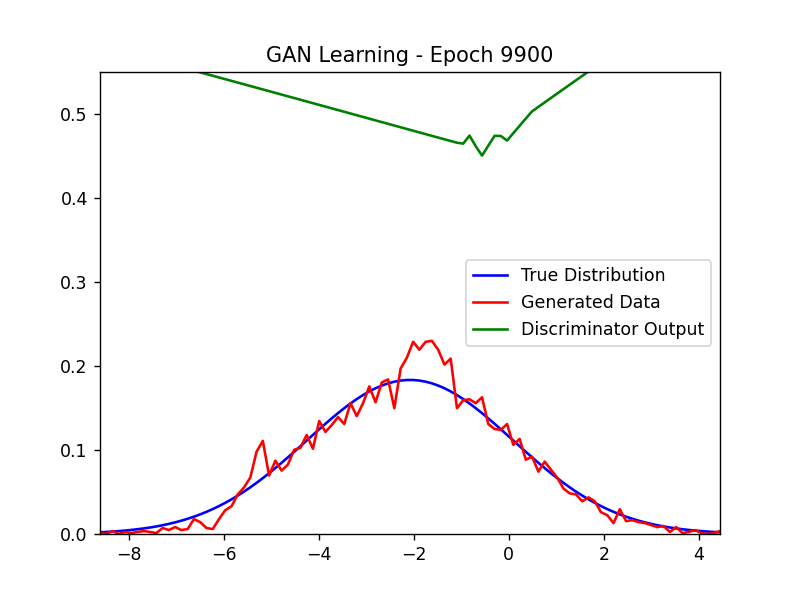

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
%matplotlib notebook
from matplotlib.animation import FFMpegWriter

def generator(z, weights):
    x = torch.relu(z @ weights["w1"] + weights["b1"])
    return x @ weights["w2"] + weights["b2"]

def discriminator(x, weights):
    x = torch.relu(x @ weights["w1"] + weights["b1"])
    return torch.sigmoid(x @ weights["w2"] + weights["b2"])

def initialize_weights():
    return {
        "w1": torch.randn(latent_dim, 16, requires_grad=True),
        "b1": torch.randn(16, requires_grad=True),
        "w2": torch.randn(16, 1, requires_grad=True),
        "b2": torch.randn(1, requires_grad=True)
    }

def initialize_discriminator_weights():
    return {
        "w1": torch.randn(1, 16, requires_grad=True),
        "b1": torch.randn(16, requires_grad=True),
        "w2": torch.randn(16, 1, requires_grad=True),
        "b2": torch.randn(1, requires_grad=True)
    }

def get_density(x, mean, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

#
def update(frame):
    fake_data_hist, _ = np.histogram(generated_data_list[frame], bins=100, 
                                     range=(true_mean - 3 * true_std, true_mean + 3 * true_std), density=True)
    line_fake.set_data(x_vals, fake_data_hist)
    line_disc.set_data(x_vals, discriminator_outputs[frame])
    ax.set_title(f'GAN Learning - Epoch {frame * 100}')
    return line_fake, line_disc

# Save the animation as MP4 and GIF
def save_animation(ani, mp4_filename, gif_filename, fps=10):
    writer = FFMpegWriter(fps=fps, metadata = dict(artist='Your Name'), extra_args=['-vcodec', 'libx264'])
    ani.save(mp4_filename, writer=writer)
    ani.save(gif_filename, writer='pillow', fps=fps)
    

##########################################################################################################################

# Hyperparameters
batch_size = 6500
latent_dim = 2  # Dimension of noise input to generator
learning_rate_G = 0.001
learning_rate_D = 0.001
num_epochs = 10000

# Ground truth data: Unknown Normal distribution (model must estimate)
true_mean = np.random.uniform(-5, 5)
true_std = np.random.uniform(1, 3)

# Initialize weights
generator_weights = {k: torch.nn.Parameter(v) for k, v in initialize_weights().items()}
discriminator_weights = {k: torch.nn.Parameter(v) for k, v in initialize_discriminator_weights().items()}

# Optimizers
optimizer_G = optim.Adam(generator_weights.values(), lr=learning_rate_G)
optimizer_D = optim.Adam(discriminator_weights.values(), lr=learning_rate_D)

# Loss function
criterion = nn.BCELoss()

generated_data_list = []
discriminator_outputs = []

# Training loop
for epoch in range(num_epochs):
    # Sample real data
    real_data = torch.randn(batch_size, 1) * true_std + true_mean
    real_labels = torch.ones(batch_size, 1)

    # Sample noise and generate fake data
    z = torch.randn(batch_size, latent_dim)
    fake_data = generator(z, generator_weights).detach()
    fake_labels = torch.zeros(batch_size, 1)
    
    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = criterion(discriminator(real_data, discriminator_weights), real_labels)
    fake_loss = criterion(discriminator(fake_data, discriminator_weights), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()
    
    # Train Generator
    optimizer_G.zero_grad()
    z = torch.randn(batch_size, latent_dim)
    generated_data = generator(z, generator_weights)
    g_loss = criterion(discriminator(generated_data, discriminator_weights), real_labels)  # Fool discriminator
    g_loss.backward()
    optimizer_G.step()
    
    # Store data for animation
    if epoch % 100 == 0:
        generated_data_list.append(generated_data.detach().numpy())
        x_vals = np.linspace(true_mean - 3 * true_std, true_mean + 3 * true_std, 100)
        discriminator_outputs.append(discriminator(torch.tensor(x_vals, dtype=torch.float32).view(-1, 1), discriminator_weights).detach().numpy())
    
    # Print progress
    if epoch % 500 == 0:
        gen_samples = generator(torch.randn(1000, latent_dim), generator_weights).detach().numpy()
        print(f'Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}, Generated Mean: {gen_samples.mean():.2f}, Std: {gen_samples.std():.2f}')

print("Training completed!")

# Create animation
fig, ax = plt.subplots()
x_vals = np.linspace(true_mean - 3 * true_std, true_mean + 3 * true_std, 100)
true_distribution = get_density(x_vals, true_mean, true_std)

line_real, = ax.plot(x_vals, true_distribution, label="True Distribution", color="blue")
line_fake, = ax.plot([], [], label="Generated Data", color="red")
line_disc, = ax.plot([], [], label="Discriminator Output", color="green")
ax.legend()
ax.set_ylim(0, max(true_distribution) * 3)
ax.set_xlim(true_mean - 3 * true_std, true_mean + 3 * true_std)

# creates the animation using the FuncAnimation function
ani = animation.FuncAnimation(fig, update, frames=len(generated_data_list), repeat=False)
plt.show()

# Save the animation in both formats
save_animation(ani, "gan_training_progress2.mp4", "gan_training_progress2.gif", fps=10)